In [14]:
from pydub import AudioSegment # pip3 install pydub
import numpy as np
import scipy.signal

from time import time

In [15]:
import matplotlib.pyplot as plt

In [16]:
track_path = 'cloud-meditation-4868_40Hz.mp3'

In [17]:
# Butterworth band filter hepler

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = scipy.signal.butter(order, [low, high], btype='band')
    return scipy.signal.lfilter(b, a, data)

In [18]:
#open track
track = AudioSegment.from_mp3(track_path)
frame_rate = track.frame_rate

#get samples from pydub to np.array
stereo_samples = np.array([ch.get_array_of_samples() for ch in track.split_to_mono()], dtype=np.float32)

t = time()
#bandpass frequencies between 200Hz and 600Hz
filtered = [butter_bandpass_filter(chan, 200.0, 600.0, frame_rate) for chan in stereo_samples]
print(time()-t)


#just multiply channels to emulate bb, and 
binaural_beats_emulation = filtered[0] * filtered[1]
am_emulation = (filtered[0] * filtered[0] + filtered[1] * filtered[1])/2

0.7433137893676758


In [19]:
#compute spectrogram

fftsize = 2 ** int(np.log2(frame_rate)+4)
_, _, Sbb = scipy.signal.spectrogram(binaural_beats_emulation, fs=track.frame_rate, nperseg=fftsize)
f, t, Sam = scipy.signal.spectrogram(am_emulation, fs=track.frame_rate, nperseg=fftsize)

In [20]:
## Postproc

#get 0.5 - 50 Hz from beats
max_freq_ind = np.argmax(f>50)
min_freq_ind = np.argmin(f<0.5)
f = f[min_freq_ind:max_freq_ind+1]
Sbb = Sbb[min_freq_ind:max_freq_ind+1,:]
Sam = Sam[min_freq_ind:max_freq_ind+1,:]

pproc = lambda S: np.log2(S+1.0) if is_log else S
max_val = lambda S: pproc(S).max()

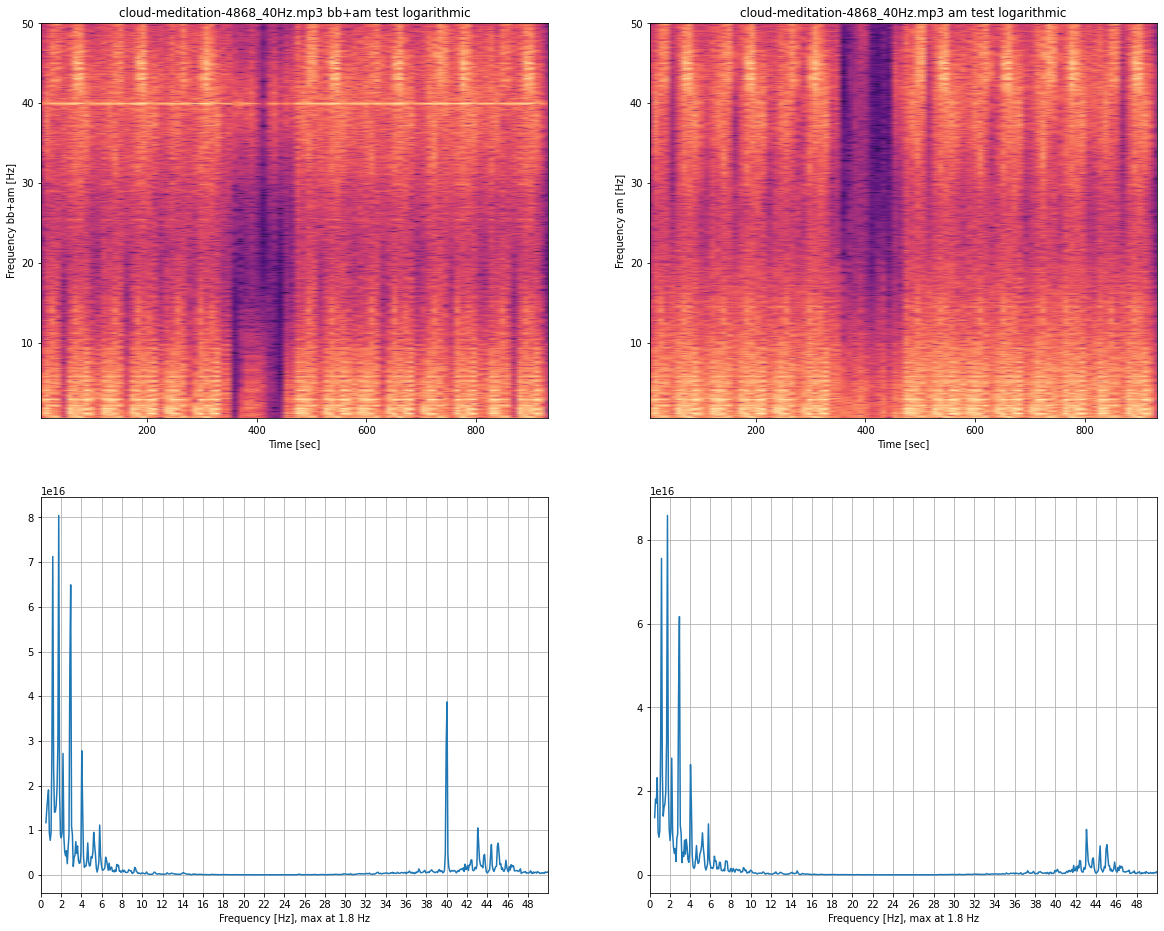

In [21]:
is_log = True

#plt.close()
plt.figure(figsize=(20,16)) 
plt.subplot(2,2,1)

plt.pcolormesh(t, f, pproc(Sbb), shading='gouraud',cmap='magma', vmax=max_val(Sbb))
plt.ylabel('Frequency bb+am [Hz]')
plt.xlabel('Time [sec]')
plt.title(f'{track_path} bb+am test {"logarithmic" if is_log else "linear"}')

plt.subplot(2,2,2)
plt.pcolormesh(t, f, pproc(Sam), shading='gouraud',cmap='magma', vmax=max_val(Sam))
plt.ylabel('Frequency am [Hz]')
plt.xlabel('Time [sec]')
plt.title(f'{track_path} am test {"logarithmic" if is_log else "linear"}')


plt.subplot(2,2,3)
plt.plot(f, Sbb.sum(1))
plt.axis(xmin=0, xmax=f.max().round())
plt.xlabel(f'Frequency [Hz], max at {f[Sbb.sum(1).argmax()].round(1)} Hz')
plt.xticks(np.arange(0, f.max().round(), 2))
plt.grid()

plt.subplot(2,2,4)
plt.plot(f, Sam.sum(1))
plt.axis(xmin=0, xmax=f.max().round())
plt.xlabel(f'Frequency [Hz], max at {f[Sam.sum(1).argmax()].round(1)} Hz')
plt.xticks(np.arange(0, f.max().round(), 2))
plt.grid()

with open(track_path.replace('.mp3', '.png'), 'wb') as fb:
    plt.savefig(fb, format="png")
